In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
import tqdm

from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torchvision.models import *

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

assert True == torch.cuda.is_available()

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [3]:
class ImageDataset(Dataset):
    def __init__(self, X, Y, train = True):
        self.X = X
        self.Y = Y
        self.train = train

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, item):
        normalize = v2.Normalize((128, 128, 128), (128, 128, 128))
        augmentations = transforms.Compose([
            v2.RandomHorizontalFlip(),
            # v2.RandomAutocontrast(),
            v2.RandomSolarize(0.4),
            # v2.RandomEqualize(0.5),
            # v2.RandomPosterize(16),
            # v2.RandomGrayscale(0.3),
            # v2.RandomPhotometricDistort(saturation=[1, 1.5], hue = [0,0], brightness=[0.875, 1.125], contrast=[0.9,1.1], p = 0.3),
            # v2.ColorJitter(saturation=[1, 1], hue = 0, brightness=[1, 1], contrast=[0.9,1.1])
        ])
        img = torchvision.io.read_image(f"trainval/{self.X[item]}").to(torch.float).to(device)
        img = normalize(img)
        if self.train:
            img = augmentations(img)
        return img, self.Y[item]

data = pd.read_csv("labels.csv")
X_train, X_val, y_train, y_val = train_test_split(data["Id"], data["Category"], test_size=0.2, random_state=42, shuffle=True)

# X_train = X_train.reset_index()["Id"]
# y_train = y_train.reset_index()["Category"]
# X_val = X_val.reset_index()["Id"]
# y_val = y_val.reset_index()["Category"]

train_dataset = ImageDataset(X_train.to_list(), y_train.to_list())
val_dataset = ImageDataset(X_val.to_list(), y_val.to_list(), False)

In [4]:
train_loader = DataLoader(train_dataset, 32, True)
val_loader = DataLoader(val_dataset, 32, True)

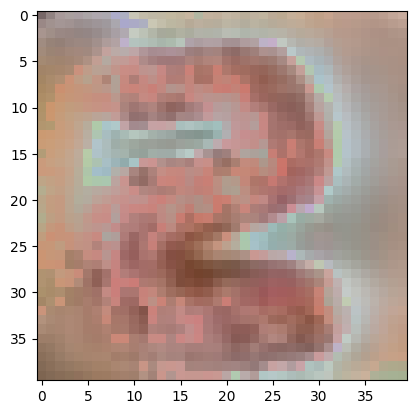

torch.Size([3, 40, 40])


In [5]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.to("cpu").numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    print(img.shape)

imshow(train_dataset[2][0])


In [6]:
# for data, target in train_loader:
#     print(data)
#     print(target)
#     break

In [7]:
@torch.no_grad()
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    criterion = F.cross_entropy
    
    for data, target in loader:

        data = data.to(device)  # images: batch_size x num_channels x height x width
        target = target.to(device)  # labels: batch_size

        logits = model(data)  # logits: batch_size x num_classes
        loss = criterion(logits, target)
    
        loss_log.append(loss.item())
        
        acc = (logits.argmax(dim=1) == target).sum() / len(target)

        acc_log.append(acc.item()) 
        
    return torch.tensor(loss_log).mean(), torch.tensor(acc_log).mean()

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    criterion = F.cross_entropy
    
    for data, target in tqdm.tqdm(train_loader):
        
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        logits = model(data)
        loss = criterion(logits, target)  # use this loss for any training statistics
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
        
        acc = (logits.argmax(dim=1) == target).sum() / len(target)
        
        acc_log.append(acc.item()) 

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch + 1} | lr={scheduler.get_last_lr()[0]}")
        print(f" train loss: {torch.tensor(train_loss).mean()}, train acc: {torch.tensor(train_acc).mean()}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        torch.save(model, "model.pth")
        
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [8]:
# net = resnet18(num_classes=200)

# net.maxpool = nn.ReLU()
# net.conv1.stride = (1, 1)
# net.layer2[0].conv1.stride = (1, 1)
# net.layer2[0].downsample[0].stride = (1, 1)

# net.layer3[0].conv2.stride = (1, 1)
# net.layer3[0].downsample[0].stride = (1, 1)

# net.layer4[0].conv2.stride = (1, 1)
# net.layer4[0].downsample[0].stride = (1, 1)

# print(net)

In [9]:
net = efficientnet_v2_s(num_classes=200)

net.features[0][0].stride = (1, 1)
net.features[2][0].block[0][0].stride = (1, 1)
# net.features[3][0].block[0][0].stride = (1, 1)

net.classifier[0].p = 0.4

# print(net)

In [10]:
# net = efficientnet_v2_s(num_classes=200)

# net(torch.zeros((64, 3, 40, 40), dtype=torch.float).to(device)).shape

In [11]:
net = net.to(device)

In [12]:
torch.manual_seed(1984)
np.random.seed(1984)
torch.cuda.manual_seed(1984)
torch.backends.cudnn.deterministic = True

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4, nesterov=True)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 20)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [8, 12], gamma=0.1)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

100%|██████████| 2500/2500 [05:00<00:00,  8.32it/s]


Epoch 1 | lr=0.01
 train loss: 5.07138204574585, train acc: 0.023087499663233757
 val loss: 4.698486328125, val acc: 0.04735000059008598



100%|██████████| 2500/2500 [05:00<00:00,  8.33it/s]


Epoch 2 | lr=0.009938441702975689
 train loss: 4.595623016357422, train acc: 0.06023750081658363
 val loss: 4.253929138183594, val acc: 0.097850002348423



100%|██████████| 2500/2500 [05:00<00:00,  8.33it/s]


Epoch 3 | lr=0.009755282581475769
 train loss: 4.189517021179199, train acc: 0.10743749886751175
 val loss: 3.8276820182800293, val acc: 0.15444999933242798



100%|██████████| 2500/2500 [04:59<00:00,  8.34it/s]


Epoch 4 | lr=0.00945503262094184
 train loss: 3.843214750289917, train acc: 0.15372499823570251
 val loss: 3.559255361557007, val acc: 0.2003999948501587



100%|██████████| 2500/2500 [04:53<00:00,  8.52it/s]


Epoch 5 | lr=0.009045084971874739
 train loss: 3.5803706645965576, train acc: 0.1965624988079071
 val loss: 3.34256911277771, val acc: 0.23315000534057617



100%|██████████| 2500/2500 [04:48<00:00,  8.66it/s]


Epoch 6 | lr=0.008535533905932738
 train loss: 3.3642032146453857, train acc: 0.23412500321865082
 val loss: 3.159925937652588, val acc: 0.27059999108314514



100%|██████████| 2500/2500 [04:47<00:00,  8.69it/s]


Epoch 7 | lr=0.007938926261462366
 train loss: 3.179798126220703, train acc: 0.2653999924659729
 val loss: 3.0359513759613037, val acc: 0.2964499890804291



100%|██████████| 2500/2500 [04:50<00:00,  8.62it/s]


Epoch 8 | lr=0.007269952498697735
 train loss: 3.0171406269073486, train acc: 0.2944999933242798
 val loss: 2.9506711959838867, val acc: 0.3143500089645386



100%|██████████| 2500/2500 [05:04<00:00,  8.20it/s]


Epoch 9 | lr=0.006545084971874738
 train loss: 2.8691422939300537, train acc: 0.32202500104904175
 val loss: 2.839942216873169, val acc: 0.3352000117301941



100%|██████████| 2500/2500 [04:48<00:00,  8.66it/s]


Epoch 10 | lr=0.005782172325201155
 train loss: 2.733691692352295, train acc: 0.3487125039100647
 val loss: 2.7540462017059326, val acc: 0.3522999882698059



100%|██████████| 2500/2500 [04:52<00:00,  8.56it/s]


Epoch 11 | lr=0.005
 train loss: 2.5994961261749268, train acc: 0.3777250051498413
 val loss: 2.694422483444214, val acc: 0.36535000801086426



100%|██████████| 2500/2500 [04:47<00:00,  8.71it/s]


Epoch 12 | lr=0.004217827674798847
 train loss: 2.4615840911865234, train acc: 0.4022125005722046
 val loss: 2.644106149673462, val acc: 0.37959998846054077



100%|██████████| 2500/2500 [04:45<00:00,  8.75it/s]


Epoch 13 | lr=0.0034549150281252636
 train loss: 2.3312108516693115, train acc: 0.4267500042915344
 val loss: 2.6070032119750977, val acc: 0.38960000872612



100%|██████████| 2500/2500 [04:46<00:00,  8.72it/s]


Epoch 14 | lr=0.0027300475013022664
 train loss: 2.1951112747192383, train acc: 0.45426249504089355
 val loss: 2.5579288005828857, val acc: 0.3977000117301941



100%|██████████| 2500/2500 [04:44<00:00,  8.80it/s]


Epoch 15 | lr=0.0020610737385376348
 train loss: 2.060258626937866, train acc: 0.48467499017715454
 val loss: 2.53922700881958, val acc: 0.4059000015258789



100%|██████████| 2500/2500 [04:45<00:00,  8.75it/s]


Epoch 16 | lr=0.0014644660940672626
 train loss: 1.9183276891708374, train acc: 0.5144000053405762
 val loss: 2.5119526386260986, val acc: 0.4180000126361847



100%|██████████| 2500/2500 [04:43<00:00,  8.81it/s]


Epoch 17 | lr=0.0009549150281252633
 train loss: 1.7938072681427002, train acc: 0.5431625247001648
 val loss: 2.502913236618042, val acc: 0.42080000042915344



100%|██████████| 2500/2500 [04:55<00:00,  8.47it/s]


Epoch 18 | lr=0.0005449673790581611
 train loss: 1.6851636171340942, train acc: 0.5683375000953674
 val loss: 2.5141258239746094, val acc: 0.4247500002384186



100%|██████████| 2500/2500 [05:24<00:00,  7.70it/s]


Epoch 19 | lr=0.00024471741852423234
 train loss: 1.6106435060501099, train acc: 0.5867999792098999
 val loss: 2.4952008724212646, val acc: 0.42879998683929443



100%|██████████| 2500/2500 [05:20<00:00,  7.79it/s]


Epoch 20 | lr=6.15582970243117e-05
 train loss: 1.5602314472198486, train acc: 0.5975124835968018
 val loss: 2.4891648292541504, val acc: 0.43035000562667847



In [13]:
# net = torch.load("model.pth", weights_only=False)
# net = net.to(device)
# net.eval()

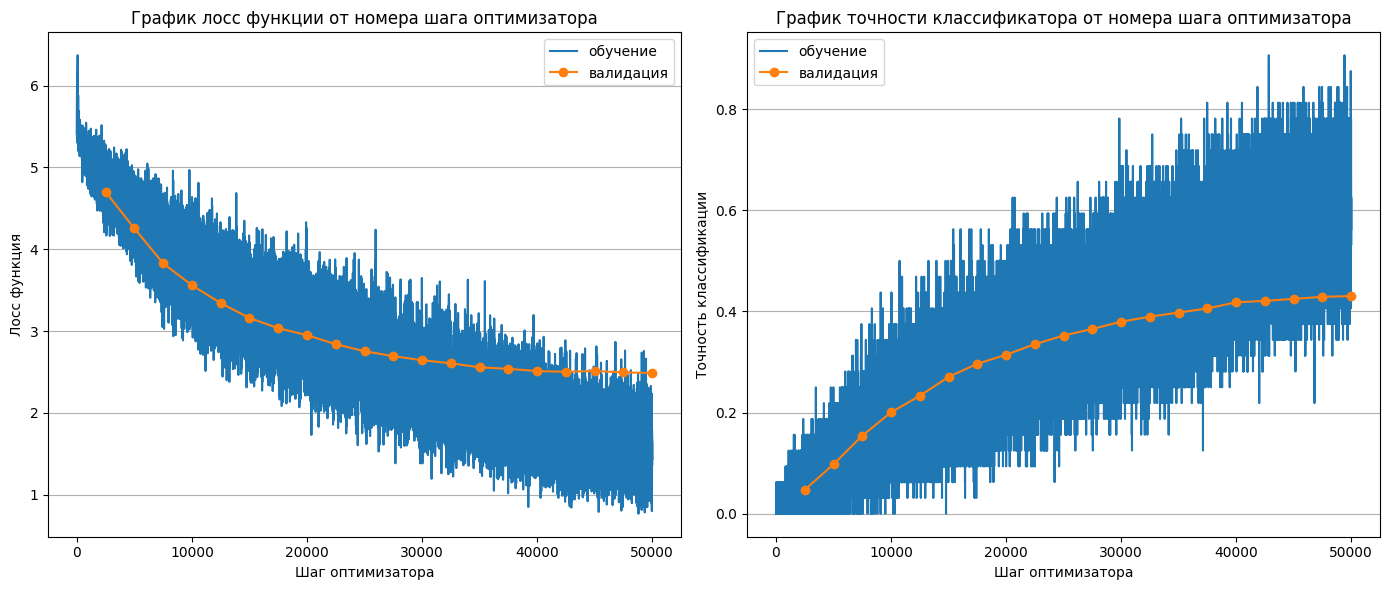

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6))

ax[0].plot(train_loss_log, label = "обучение")
ax[0].plot((torch.arange(len(val_loss_log)) + 1) * len(train_loader), val_loss_log, label = "валидация", marker = "o")
ax[0].set_xlabel("Шаг оптимизатора")
ax[0].set_ylabel("Лосс функция")
ax[0].set_title("График лосс функции от номера шага оптимизатора")
ax[0].grid(axis = "y")
ax[0].legend()


ax[1].plot(train_acc_log, label = "обучение")
ax[1].plot((torch.arange(len(val_acc_log)) + 1) * len(train_loader), val_acc_log, label = "валидация", marker = "o")
ax[1].set_xlabel("Шаг оптимизатора")
ax[1].set_ylabel("Точность классификации")
ax[1].set_title("График точности классификатора от номера шага оптимизатора")
ax[1].grid(axis = "y")
ax[1].legend()

plt.tight_layout()
plt.show()

In [15]:
files = [file for file in os.listdir("test")]

pred = []

with torch.no_grad():
    for i in tqdm.tqdm(range(len(files))):
        file = files[i]
        transform = v2.Normalize((128, 128, 128), (128, 128, 128))
        img = torchvision.io.read_image(f"test/{file}").to(torch.float).to(device)
        img = transform(img).unsqueeze(0)
        logits = net(img)[0]
        pred.append(int(logits.argmax().to("cpu")))


100%|██████████| 10000/10000 [03:31<00:00, 47.19it/s]


In [16]:
data = {
    "Id" : files,
    "Category" : pred
}

df = pd.DataFrame(data)

In [17]:
df.to_csv("labels_test.csv", index=False)